# Fantasy Football Roster Predictions

## Problem
Can a model predict a fantasy football roster that can win a fantasy football league?  

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_CONFIG_DIR'] = r'C:\Users\omend\.kaggle'

api = KaggleApi()
api.authenticate()

api.dataset_download_files("philiphyde1/nfl-stats-1999-2022", path=r"./data", unzip=True)
print("Download Complete!")

Dataset URL: https://www.kaggle.com/datasets/philiphyde1/nfl-stats-1999-2022
Download Complete!


In [2]:
#Data load and ETL
import pandas as pd
import numpy as np

# Feature engineering and preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#4 REgression & Machine learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,recall_score, precision_score, f1_score
import xgboost as xgb
from xgboost import XGBRegressor

# Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#simple Collaborative FIltering with surprise
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

#Time series Forecasting
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


# Recommendation & Optimization
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linprog
import pulp

In [3]:
yearly_data_off = pd.read_csv('./data/yearly_player_stats_offense.csv', encoding='utf-8')
yearly_data_def = pd.read_csv('./data/yearly_player_stats_defense.csv', encoding='utf-8')

weekly_data_off = pd.read_csv('./data/weekly_player_stats_offense.csv')
print(yearly_data_off.head(10))
print(weekly_data_off.head(5))

    player_id      player_name position  birth_year  draft_year  draft_round  \
0  00-0000865    Charlie Batch       QB        1974      1998.0          2.0   
1  00-0004541    Donald Driver       WR        1975      1999.0          7.0   
2  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
3  00-0006101    Tony Gonzalez       TE        1976      1997.0          1.0   
4  00-0007091  Matt Hasselbeck       QB        1975      1998.0          6.0   
5  00-0010346   Peyton Manning       QB        1976      1998.0          1.0   
6  00-0010346   Peyton Manning       QB        1976      1998.0          1.0   
7  00-0011754       Randy Moss       WR        1977      1998.0          1.0   
8  00-0011754       Randy Moss       WR        1977      1998.0          1.0   
9  00-0015754  Brandon Stokley       WR        1976      1999.0          4.0   

   draft_pick  draft_ovr  height  weight  ... delta_comp_pct  delta_int_pct  \
0        30.0       60.0    74.0   216.0

In [4]:
yearly_data_off.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133 entries, 0 to 7132
Columns: 660 entries, player_id to delta_yptouch
dtypes: float64(647), int64(5), object(8)
memory usage: 35.9+ MB


In [5]:
#Filter only 2021-2024 seasons
yearly_data_off = yearly_data_off[yearly_data_off['season'].isin([2021,2022,2023, 2024])]
weekly_data_off = weekly_data_off[weekly_data_off['season'].isin([2021, 2022, 2023, 2024])]

In [6]:
#drop players with no games played

yearly_data_off = yearly_data_off[yearly_data_off['games_played_season'] > 0]
weekly_data_off = weekly_data_off[weekly_data_off['games_played_season'] > 0]

# Feature Engineering

In [7]:
#Keep some aggregate features
yearly_features = yearly_data_off[['player_id', 'player_name','season', 'passing_yards','pass_touchdown',
                                   'rushing_yards','rush_touchdown','receptions','receiving_yards',
                                   'receiving_touchdown','fantasy_points_ppr']]

In [13]:
# rolling averages: last 3 weeks players
weekly_data_off = weekly_data_off.sort_values(['player_id','season','week'])

weekly_data_off['fp_last3'] = (
    weekly_data_off.groupby('player_id')['fantasy_points_ppr'].transform(lambda x: x.rolling(3, min_periods=1).mean())
)

weekly_features = weekly_data_off[['player_id','player_name','season','week','passing_yards','pass_touchdown',
                                   'rushing_yards','rush_touchdown','receptions','receiving_yards',
                                   'receiving_touchdown','fantasy_points_ppr','fp_last3']]

In [14]:
#Merge yearly summary into weekly data
data_merged = weekly_features.merge(yearly_features, on=['player_id','season'],
                                    suffixes=('_weekly','_yearly'))

print(data_merged.dtypes)

player_id                      object
player_name_weekly             object
season                          int64
week                            int64
passing_yards_weekly          float64
pass_touchdown_weekly         float64
rushing_yards_weekly          float64
rush_touchdown_weekly         float64
receptions_weekly             float64
receiving_yards_weekly        float64
receiving_touchdown_weekly    float64
fantasy_points_ppr_weekly     float64
fp_last3                      float64
player_name_yearly             object
passing_yards_yearly          float64
pass_touchdown_yearly         float64
rushing_yards_yearly          float64
rush_touchdown_yearly         float64
receptions_yearly             float64
receiving_yards_yearly        float64
receiving_touchdown_yearly    float64
fantasy_points_ppr_yearly     float64
dtype: object


In [16]:
# -----------------------------
# 1. Define features and target
# -----------------------------
features = [
    'passing_yards_weekly', 'pass_touchdown_weekly', 'rush_touchdown_weekly',
    'receptions_weekly', 'receiving_yards_weekly', 'receiving_touchdown_weekly',
    'fp_last3', 'passing_yards_yearly', 'rushing_yards_yearly'
]
target = 'fantasy_points_ppr_weekly'

df_model = data_merged[features + [target]].dropna().copy()

# -----------------------------
# 2. Train/test split
# -----------------------------
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# -----------------------------
# 3. Linear Regression (scaled features)
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Linear Regression:")
print(" MAE:", mean_absolute_error(y_test, y_pred_lr))
print(" RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print(" R2:", r2_score(y_test, y_pred_lr))

# -----------------------------
# 4. XGBoost (raw features, no scaling)
# -----------------------------
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=23)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\nXGBoost:")
print(" MAE:", mean_absolute_error(y_test, y_pred_xgb))
print(" RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print(" R2:", r2_score(y_test, y_pred_xgb))

Linear Regression:
 MAE: 1.169156495621053
 RMSE: 1.9083239885746144
 R2: 0.9539634954418506

XGBoost:
 MAE: 1.1398341526730627
 RMSE: 1.8501981995023364
 R2: 0.9567252437842341


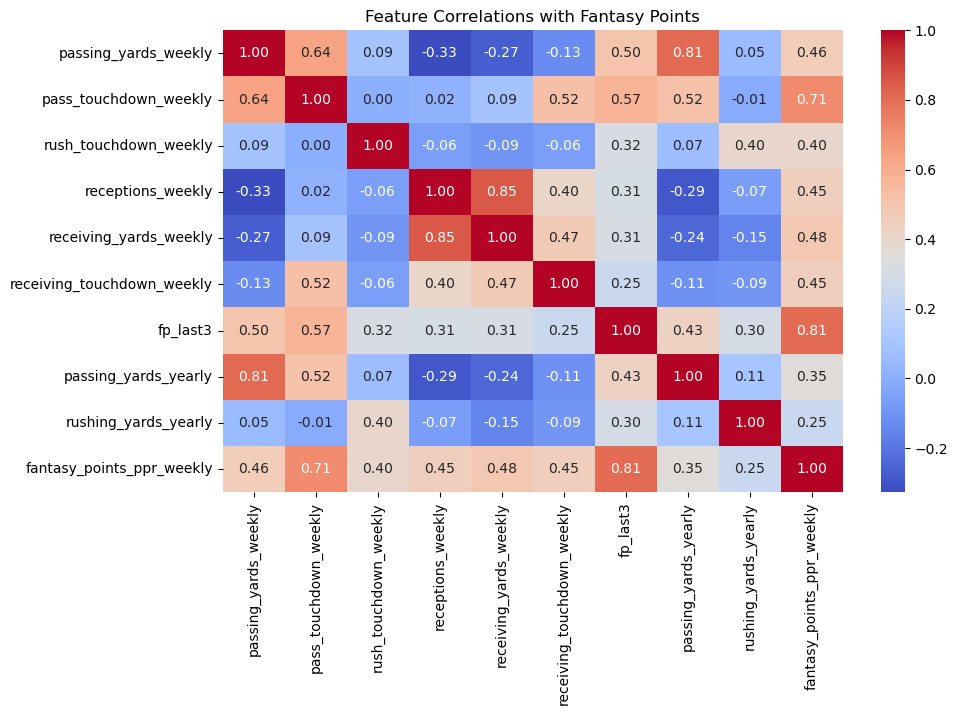

In [15]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_model.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations with Fantasy Points")
plt.show()


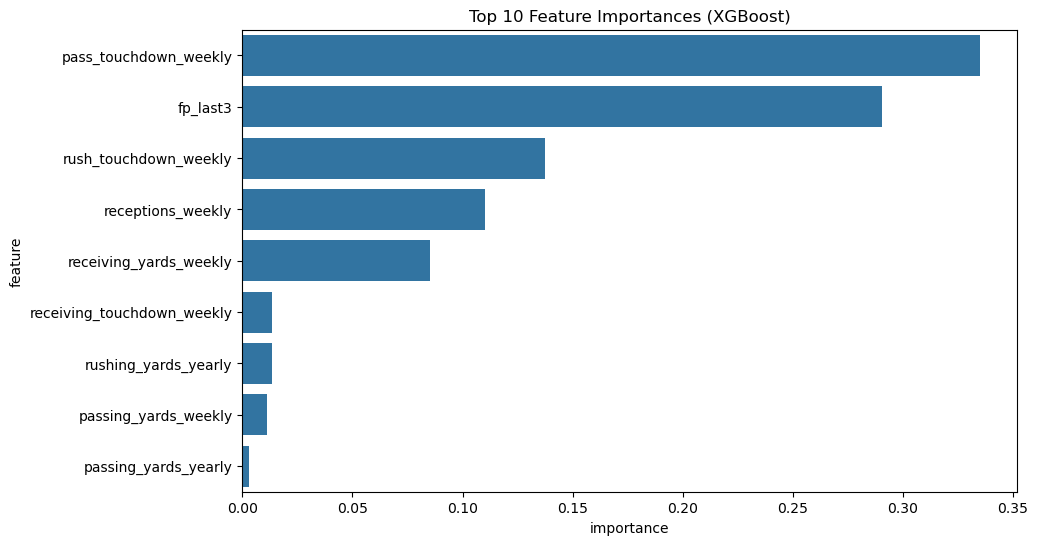

In [10]:
# Feature importance
importances = xgb.feature_importances_
feat_importance = pd.DataFrame({
    'feature': features,  # your original feature list
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_importance.head(10))
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()


##### Advanced Regression / Prediction Models

In [11]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=23)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest r2:", r2_score(y_test,y_pred_rf))

Random Forest r2: 0.9546989326508935


In [12]:
xgb = XGBRegressor(n_estimators=100, 
                    learning_rate=0.05, 
                    max_depth=6, 
                    random_state=23)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
print('XGBoost R2:', r2_score(y_test, y_pred_xgb))


XGBoost R2: 0.9553527317733034


In [13]:
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

nn.compile(optimizer='adam', loss='mse')
nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_nn = nn.predict(X_test_scaled).flatten()
print("Neural Network R2:", r2_score(y_test, y_pred_nn))

c:\Users\omend\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Neural Network R2: 0.9591108285284315


Visualizations

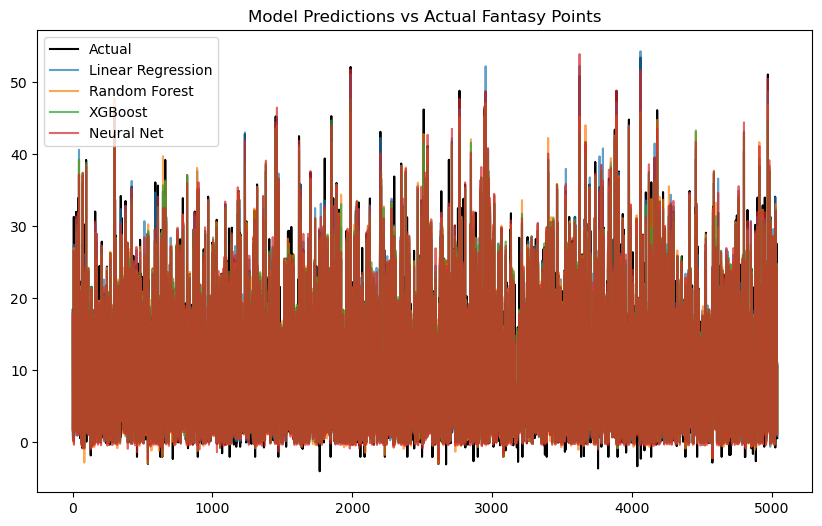

In [14]:
models = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "Neural Net": y_pred_nn
}

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="black")

for name, preds in models.items():
    plt.plot(preds, label=name, alpha=0.7)

plt.legend()
plt.title("Model Predictions vs Actual Fantasy Points")
plt.show()


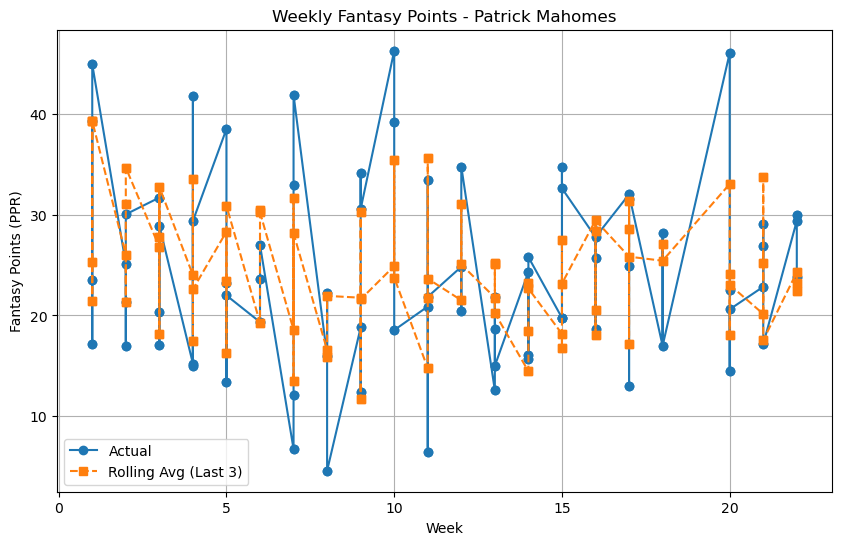

In [20]:
# --- Player Weekly Trend ---
player = "Patrick Mahomes"
df_player = data_merged[data_merged['player_name_weekly'] == player].sort_values("week")

plt.figure(figsize=(10,6))
plt.plot(df_player["week"], df_player["fantasy_points_ppr_weekly"], marker="o", label="Actual")
plt.plot(df_player["week"], df_player["fp_last3"], marker="s", linestyle="--", label="Rolling Avg (Last 3)")
plt.title(f"Weekly Fantasy Points - {player}")
plt.xlabel("Week")
plt.ylabel("Fantasy Points (PPR)")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\omend\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

Next 3 weeks forecast for Patrick Mahomes: [22.70428567386528, 24.24031488756198, 24.504169288543967]


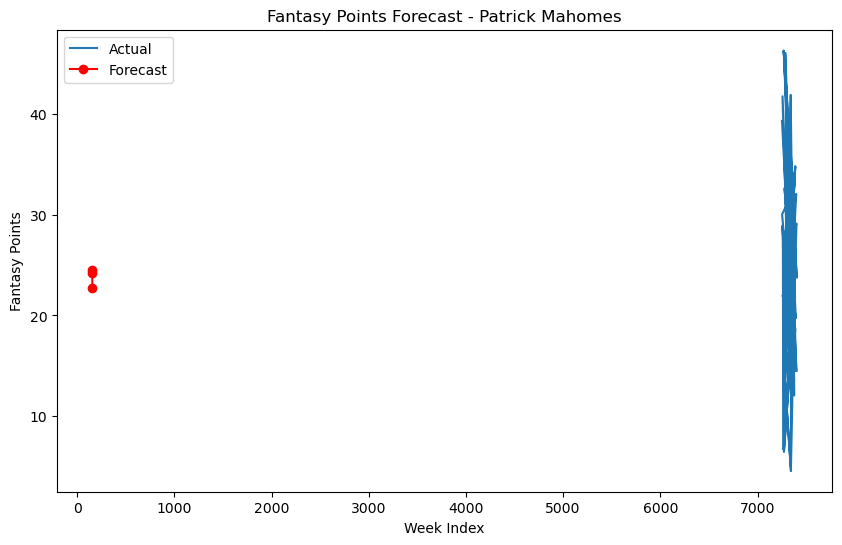

In [24]:
ts = df_player['fantasy_points_ppr_weekly']

# Fit ARIMA
model = ARIMA(ts, order=(2,1,2))  # tune p,d,q
model_fit = model.fit()

# Forecast next 3 weeks
forecast = model_fit.forecast(steps=3)
print(f"Next 3 weeks forecast for {player}: {forecast.tolist()}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(ts.index, ts, label="Actual")
plt.plot(range(len(ts), len(ts)+3), forecast, marker="o", label="Forecast", color="red")
plt.title(f"Fantasy Points Forecast - {player}")
plt.xlabel("Week Index")
plt.ylabel("Fantasy Points")
plt.legend()
plt.show()